## DEPENDENCIES MANAGEMENT

#### You should run all code cells step-by-step.

In [ ]:
!pip install cognite-sdk-core install pandas install ipywidgets
from cognite.client import CogniteClient
import requests
import json
import pandas as pd
pd.set_option('display.max_rows', None)

## PRESET PARAMETERS

### Default parameters

In [3]:
BASE_API='https://datapop.greenfield.cognite.ai'
GRAPHQL_ENDPOINT = f'{BASE_API}/v1/graphql'
CDF_URL = "https://api.cognitedata.com"
TOKEN_SCOPES = ["https://api.cognitedata.com/.default"]
TOKEN_URL = "https://login.microsoftonline.com/806128be-974c-452a-a25c-f98d78eb24ea/oauth2/v2.0/token"

### User injected parameters

#### Generic parameters
<br>Here you should enter your CDF user client id and secret (ask your Admin if you do not know it) for cluster and project, those data is used to authenticate your user for making requests
<br>We use 'api' cluster and 'itg-testing' project by default, but you can set yours. Your client must have access to raw data you plan to transform.

In [ ]:
CLIENT_ID = input("Type in your client ID...")
CLIENT_SECRET = input("Type in your client secret...")
CDF_CLUSTER = input('Type in your CDF Cluster(e.g. api, westeurope-1, etc) or press Enter for "api"...') or 'api'# "api"  # api, westeurope-1 etc
COGNITE_PROJECT = input('Type in your Cognite project name or press Enter for "itg-testing"...') or 'itg-testing' # "itg-testing"

## AUTHENTICATION (part 1)

### Connect to Cognite project
<br> Here we try to connect to CDF with Cognite Client secrets you have provided.

In [ ]:
SCOPES = [f"https://{CDF_CLUSTER}.cognitedata.com/.default"]
cdf_client = CogniteClient(
    token_url=TOKEN_URL,
    token_client_id=CLIENT_ID,
    token_client_secret=CLIENT_SECRET,
    token_scopes=SCOPES,
    project=COGNITE_PROJECT,
    base_url=f"https://{CDF_CLUSTER}.cognitedata.com",
    client_name="client_secret_test_script",
    debug=True,
)

# Flow run specific parameters
 #####Here we enter parameters required for destination of data
 <br>
 <br>You need to have target schema where data will be transferred.
 <br>You need to login to https://itg.cognite.ai/ and choose your tenant to login.
 <br>There you should select/create your project(Solution) and schema here.
 <br>You can read more about login, project and schema creation here https://itg.cognite.ai/docs/#login-with-project-name
 <br>If you have pointed on selected schema in selected project in your browser,
 <br>you will have link address like: https://itg.cognite.ai/<b>tenant</b>/projects/<b>projectId</b>/data_mapping/<b>schemaName</b>?method=oauth
 <br>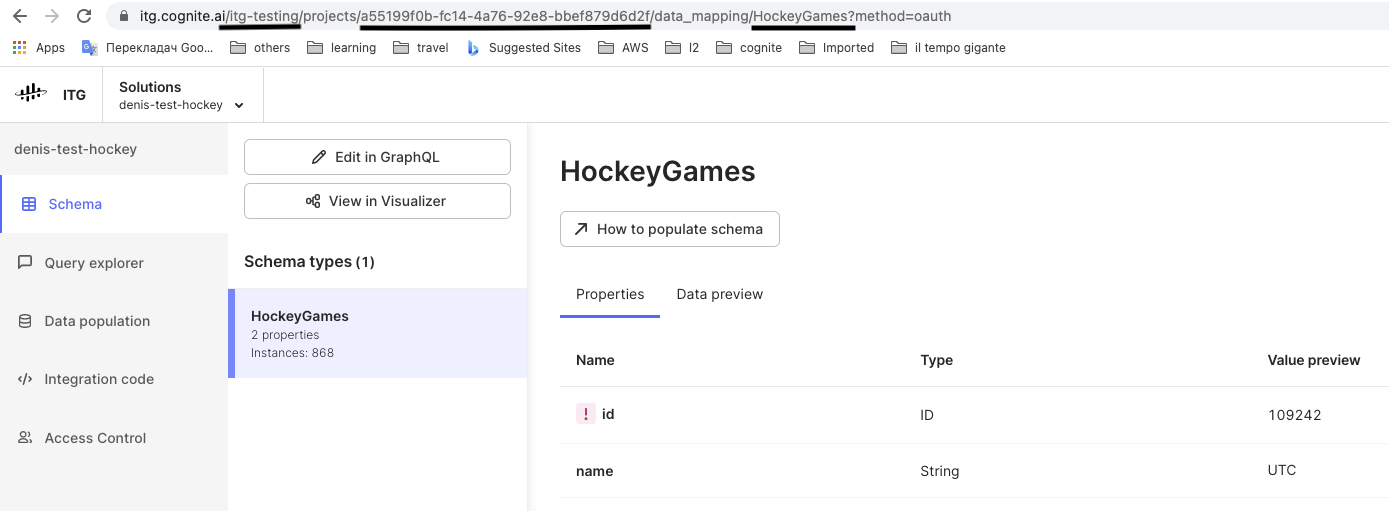
 <br>You should enter your tenant, projectId and schemaName below:

In [ ]:
# Tenant's name
# Tenant's name is project name, where raw data is stored,
# your previous entered client parameters must be sufficient
# to connect this project with READ access.
tenant = input('Type in your tenant name (usually same as Cognite project name, press Enter in that case)') or COGNITE_PROJECT
print('Tenant is ' + tenant)

In [ ]:
# ITG project ID.
# Project id is unique identifier for stored data.
projectId = input('Type in your project ID...')
print('projectId is ' + projectId)

In [ ]:
# ITG schema name
# This is schema name for data to be stored after transformation.
schemaName = input('Type in your target/destination schema name...')
print('schemaName is ' + schemaName)

##### Now we set data source
<br>Here we point raw Database name and Table name to take data from there.
<br> Also we set here batch size integer values for taking and storing data.

In [ ]:
# Here is optional cell to call list of available raw databases for you
cdf_client.raw.databases.list()

In [ ]:
# CDF raw database name
rawDatabase = input('Type in your CDF raw database name...')

In [ ]:
# Here is optional cell to call list of available raw tables in selected database
cdf_client.raw.tables.list(rawDatabase)

In [ ]:
# CDF raw table name
rawTable = input('Type in your CDF raw database table name...')

# Raw batch size
_rawBatchSize = input('Type in your raw batch size (must be an integer and defaults to a 100 if invalid value provided)...')
rawBatchSize = 100
try:
    rawBatchSize = int(_rawBatchSize.strip())
except:
    print(f'Invalid raw batch size value provided, defaulting to {rawBatchSize}...')

# ITG batch size
_itgBatchSize = input('Type in your ITG batch size (must be an integer and defaults to a 10 if invalid value provided)...')
itgBatchSize = 10
try:
    itgBatchSize = int(_itgBatchSize.strip())
except:
    print(f'Invalid ITG batch size value provided, defaulting to {itgBatchSize}...')

In [ ]:
# Here is optional cell to show some data stored in selected raw table
cdf_client.raw.rows.list(rawDatabase, rawTable, limit=5)

##### Here we enter JSONata transformation code to transform data from source to destination
<br>We need to enter here json text value that could be prepared with https://try.jsonata.org/ editor.
<br>Read more about JSONata: https://docs.jsonata.org/overview.html
##### Example of jsonata value:
<br>{
<br>	"id": id,
<br>	"name": timezone
<br>}
<br>Here 'id' values from source raw table will be transferred to 'id' field in destination schema.
<br>'timezone' values will be transferred to 'name' in destination schema.
<br>
<br>You have selected already your source table and destination schema so set here
<br>what Raw fields must be transported (and transformed if you need that) to what Schema fields

In [ ]:
# JSONata transformation code
jsonata = input('Type in your (JSONata) transformation code...')

## AUTHENTICATION (part 2)

### Get CDF authentication token
<br> Client provide us with cognite authorization token, which is expired with time.

In [ ]:
cognite_token = cdf_client.config.token()

### Get token
<br>Here token is enriched with data, required to get access to GraphQL server.

In [ ]:
token_response = requests.get(
    f'https://datapop-auth.greenfield.cognite.ai/token', headers={
        "Authorization": f"Bearer {cognite_token}",
        "x-project": 'itg-testing',
        "x-cluster": 'api'
    }
).json()
token = token_response['token']

### Configure authentication header
<br>Token is added to headers part for following request.
<br>You will see part of token printed below after running next cell.

In [ ]:
headers = {"Authorization": f"Bearer {token}", "Content-Type": "application/json"}
print("Authorization:", headers["Authorization"][0:30], "...")
cdf_client.raw.rows.list('hockey', 'games', limit=10)

## Get Flow ID
<br> Here we fetch flowId for our flow.

### Flow ID retrieval query
<br>We plan to move data from raw to schema so we prepare a call GraphQL server to get id for such version of flow:

In [ ]:
queryGetFlowId = """query GetRawToSchemaFlowId{
 flow(
   where: { name: { _eq: "raw-to-schema" }, archived: { _eq: false } }
   limit: 1
 ) {
   id
 }
}"""

### Fetch flow ID
<br>And here we call GraphQL server to fetch flow id with our query above

In [ ]:
r = requests.post(GRAPHQL_ENDPOINT, json={"query": queryGetFlowId}, headers=headers)
if r.status_code == 200:
    flowId = r.json()['data']['flow'][0]['id']
    print(flowId)
else:
    raise Exception(f"Query failed to run with a {r.status_code}.")

## TRANSFORMATIONS

### Parameters
##### Now we plan to start transformation, and all previous entered data is set as parameters for a call to GraphQl server.

In [ ]:
'''
Run multiple transformations on one flow.
'''
transformations = [
    {
        "clientId": CLIENT_ID,
        "clientSecret": CLIENT_SECRET,
        "cdfBaseUrl": CDF_URL,
        "tokenScopes": TOKEN_SCOPES,
        "tokenUrl": TOKEN_URL,
        "cdfCluster": "api",
        "cdfProject": tenant,
        "targetProjectId": projectId,
        "targetSchemaType": schemaName,
        "jsonataTransformation": jsonata,
        "rawDb": rawDatabase,
        "rawTable": rawTable,
        "rawBatchSize": rawBatchSize,
        "itgBatchSize": itgBatchSize,
        "forceReload": True
    },
    {
        "clientId": CLIENT_ID,
        "clientSecret": CLIENT_SECRET,
        "cdfBaseUrl": CDF_URL,
        "tokenScopes": TOKEN_SCOPES,
        "tokenUrl": TOKEN_URL,
        "cdfCluster": "api",
        "cdfProject": tenant,
        "targetProjectId": projectId,
        "targetSchemaType": schemaName,
        "jsonataTransformation": jsonata,
        "rawDb": rawDatabase,
        "rawTable": rawTable,
        "rawBatchSize": rawBatchSize,
        "itgBatchSize": itgBatchSize,
        "forceReload": True
    }
]

parameters = {
    'transformationConfigs': transformations
}

### Parameters variables

In [ ]:
parametersRunFlow = {
    "flow_id": flowId,
    "parameters": parameters
}

### Run flow query
##### Here we start our transformation

In [ ]:
mutationRunFlow = """mutation RunFlow($flow_id: UUID!, $parameters: JSON) {
    create_flow_run(input: {
        flow_id: $flow_id,
        parameters: $parameters
    }) {
        id
    }
}"""


In [ ]:
r = requests.post(GRAPHQL_ENDPOINT, json={"query": mutationRunFlow, "variables": parametersRunFlow}, headers=headers)
if r.status_code == 200:
    print(f"Running flow = {json.dumps(r.json(), indent=2)}")
else:
    raise Exception(f"Query failed to run with a {r.status_code}.")

## WATCH TRANSFORMATION
##### Now we want to see our transformation

In [ ]:
queryGetLastTasks = """query GetLastTasks($flow_id: uuid) {
  flow_run(
    where: { flow_id: { _eq: $flow_id }}
    limit: 5,
    order_by: {start_time: desc}
  ) {
    id
    name
    created
    agent_id
    flow_id
  }
}"""

parametersGetLastTasks = {
    "flow_id": flowId,
}


In [ ]:
r = requests.post(GRAPHQL_ENDPOINT, json={"query": queryGetLastTasks, "variables": parametersGetLastTasks}, headers=headers)
if r.status_code == 200:
    lastFlowRunId = r.json()['data']['flow_run'][0]['id']
    result = r.json()
    print('Last added transformation id is ' + lastFlowRunId)
else:
    raise Exception(f"Query failed to run with a {r.status_code}.")

In [ ]:
import time
# Need to sleep a little to take status of the last task run
time.sleep(len(transformations) * 30)

In [ ]:
getStatusQuery = """query GetStatusQuery($flowRunId: uuid){
  flow_run(
    where: {
      id: {
        _eq: $flowRunId
      }
    })
    {
      end_time
      heartbeat
      logs {
        id
        created
        message
        level
      }
  }
}"""

parametersGetStatusQuery = {
    "flowRunId": lastFlowRunId,
}

In [ ]:
#Here we call our status query to get list of logs for our transformation. Result is shown as JSON we received in response.
r = requests.post(GRAPHQL_ENDPOINT, json={"query": getStatusQuery, "variables": parametersGetStatusQuery}, headers=headers)
if r.status_code == 200:
    r.json()
else:
    raise Exception(f"Query failed to run with a {r.status_code}.")

In [ ]:
#Show logs in table
pd.json_normalize(r.json()['data']['flow_run'][0]['logs'])
